# 01 - Exploratory Data Analysis (EDA) — SKU + Línea de Producto

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# === Setup de rutas y guardado interno ===
import sys
from pathlib import Path
cwd = Path.cwd().resolve()
project_root = None
for p in [cwd] + list(cwd.parents):
    if (p / "src").exists():
        project_root = p; break
if project_root is None:
    project_root = Path("/content/drive/MyDrive/Proyecto 4")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
from src.utils.helpers import ensure_dirs
ensure_dirs(project_root / "data/processed", project_root / "models/trained_models",
            project_root / "models/model_configs", project_root / "docs")
print(" Project root:", project_root)

 Project root: /content/drive/MyDrive/Proyecto 4


In [4]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from src.data.loaders import load_sales_data, load_external_data, assign_product_line
from src.features.build_features import build_features

sales = load_sales_data(); ext = load_external_data()
for d in (sales, ext):
    d["date"] = pd.to_datetime(d["date"], errors="coerce").dt.tz_localize(None).dt.normalize()

if "product_line" not in sales.columns or sales["product_line"].isna().all():
    if "sku" in sales.columns:
        sales["product_line"] = sales["sku"].map(assign_product_line)
    else:
        sales["sku"] = "SKU_UNICO"; sales["product_line"] = "Linea_UNICA"

num_cols = sales.select_dtypes(include=[np.number]).columns.tolist()
agg = {c: ('sum' if c in ['sales'] else 'mean') for c in num_cols}
sales_by = sales.groupby(['date','sku','product_line'], as_index=False).agg(agg)

df = sales_by.merge(ext, on='date', how='left')
df = build_features(df)
print(df.head())
out = project_root / 'data' / 'processed' / 'sales.csv'
df.to_csv(out, index=False); print('Guardado:', out)

        date sku product_line  store_id  price  inventory  competitor_price  \
0 2023-01-01   D      Lácteos      47.0   7.78      113.0             13.97   
1 2023-01-02   B       Snacks      28.0   9.17      470.0             10.03   
2 2023-01-03   C     Limpieza      32.0  14.14      465.0              5.23   
3 2023-01-04   D      Lácteos       6.0   8.87      481.0             12.22   
4 2023-01-05   D      Lácteos      20.0   4.09      248.0             14.99   

   promo  sales  holiday  rain_mm         cpi  dow  week  month  
0    1.0    111        1     2.24  100.000000    6    52      1  
1    0.0     89        0     1.50  100.012531    0     1      1  
2    1.0     95        0     1.33  100.025063    1     1      1  
3    0.0    105        0     0.41  100.037594    2     1      1  
4    0.0    106        0     1.94  100.050125    3     1      1  
Guardado: /content/drive/MyDrive/Proyecto 4/data/processed/sales.csv


## 📊 Análisis Descriptivo Ampliado

In [5]:
# --- Perfil básico del dataset ---
import pandas as pd, numpy as np
from pathlib import Path
from src.utils.helpers import ensure_dirs

print("Filas x Columnas:", df.shape)
print("\nColumnas y tipos:")
print(df.dtypes)

# Rango temporal
fmin, fmax = pd.to_datetime(df['date']).min(), pd.to_datetime(df['date']).max()
print("\nRango de fechas:", fmin, "→", fmax, "| días:", (fmax - fmin).days + 1)

# Cardinalidades
for c in ['store_id','product_line','sku']:
    if c in df.columns:
        print(f"#{c} únicos:", df[c].nunique())


Filas x Columnas: (400, 15)

Columnas y tipos:
date                datetime64[ns]
sku                         object
product_line                object
store_id                   float64
price                      float64
inventory                  float64
competitor_price           float64
promo                      float64
sales                        int64
holiday                      int64
rain_mm                    float64
cpi                        float64
dow                          int32
week                         int64
month                        int32
dtype: object

Rango de fechas: 2023-01-01 00:00:00 → 2024-02-04 00:00:00 | días: 400
#store_id únicos: 50
#product_line únicos: 4
#sku únicos: 4


In [6]:
# --- Nulos y duplicados ---
miss = df.isna().mean().sort_values(ascending=False).rename("pct_missing").to_frame()
dups = df.duplicated().sum()
print("Duplicados:", dups)
display(miss.head(20))


Duplicados: 0


,pct_missing
date,0.0
sku,0.0
product_line,0.0
store_id,0.0
price,0.0
inventory,0.0
competitor_price,0.0
promo,0.0
sales,0.0
holiday,0.0


In [7]:
# --- Estadísticos globales y por línea ---
metrics = ['sales','price','competitor_price','inventory']
stats_global = df[metrics].describe().T
by_line = df.groupby('product_line')[metrics].agg(['count','mean','std','min','median','max']).round(2)
display(stats_global)
display(by_line.head(10))

# Guardar resumen a docs/
ensure_dirs(project_root / 'docs', project_root / 'docs' / 'figures')
stats_global.to_csv(project_root / 'docs' / 'eda_resumen_global.csv')
by_line.to_csv(project_root / 'docs' / 'eda_resumen_por_linea.csv')
print(" Guardados: docs/eda_resumen_global.csv y docs/eda_resumen_por_linea.csv")


,count,mean,std,min,25%,50%,75%,max
sales,400.0,88.887500,17.330485,53.00,74.7500,91.00,102.2500,133.00
price,400.0,11.593175,4.901862,3.05,7.5325,11.54,15.9025,19.95
competitor_price,400.0,11.767325,4.953414,3.01,7.3450,12.10,16.1625,20.00
inventory,400.0,282.130000,133.495020,50.00,166.5000,287.00,400.2500,499.00


sales                               price                     \
             count   mean    std min median  max count   mean   std   min   
product_line                                                                
Bebidas         99  90.44  19.24  53   93.0  133    99  11.27  5.12  3.24   
Limpieza       104  89.05  17.46  57   91.0  124   104  11.53  4.94  3.05   
Lácteos         89  89.46  15.94  61   91.0  133    89  11.22  4.75  3.08   
Snacks         108  86.83  16.49  54   88.5  129   108  12.26  4.79  3.12   

              ... competitor_price                     inventory          \
              ...              std   min median    max     count    mean   
product_line  ...                                                          
Bebidas       ...             4.95  3.01  12.28  19.99        99  298.14   
Limpieza      ...             5.12  3.17  12.23  19.81       104  280.39   
Lácteos       ...             4.79  3.05  10.91  19.85        89  274.85   
Snacks        ...             4.94  3.06  12.44  20.00       108  275.12   

                                          
                 std   min median    max  
product_line                              
Bebidas       138.15  53.0  318.0  495.0  
Limpieza      132.80  59.0  285.5  499.0  
Lácteos       139.05  55.0  279.0  499.0  
Snacks        125.54  50.0  268.0  495.0  

[4 rows x 24 columns]

 Guardados: docs/eda_resumen_global.csv y docs/eda_resumen_por_linea.csv


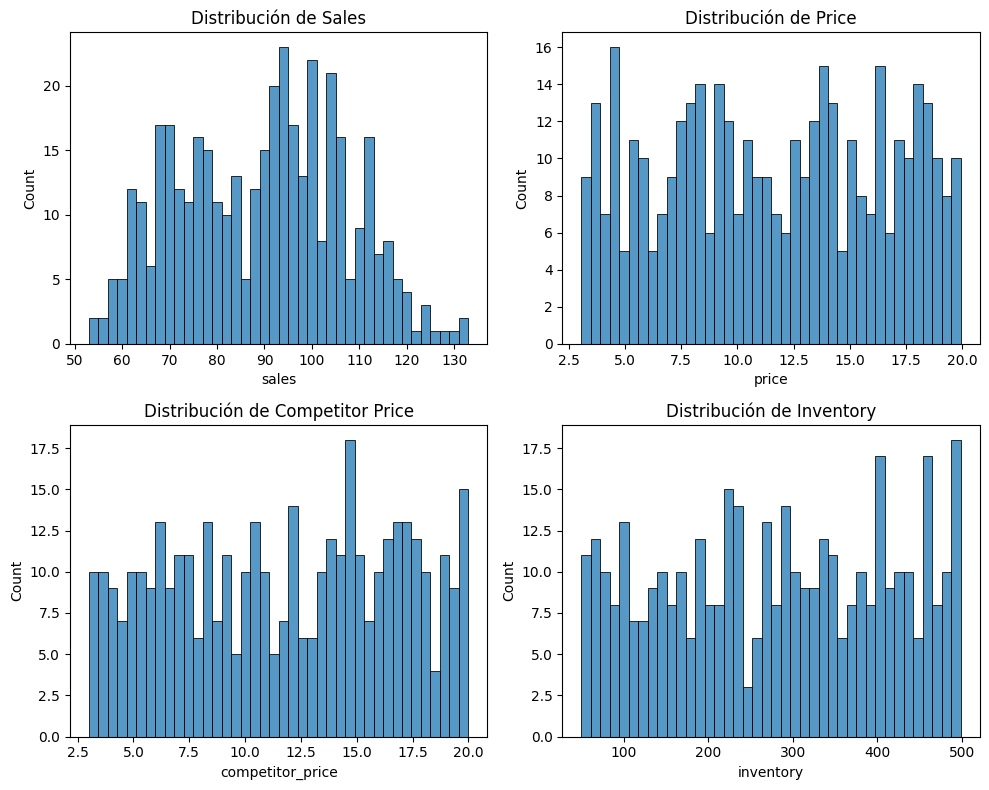

 Figura: docs/figures/dist_histograms.png


In [8]:
# --- Distribuciones (histogramas) ---
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(10,8))
sns.histplot(df['sales'], bins=40, ax=axes[0,0]); axes[0,0].set_title('Distribución de Sales')
sns.histplot(df['price'], bins=40, ax=axes[0,1]); axes[0,1].set_title('Distribución de Price')
if 'competitor_price' in df.columns:
    sns.histplot(df['competitor_price'], bins=40, ax=axes[1,0]); axes[1,0].set_title('Distribución de Competitor Price')
if 'inventory' in df.columns:
    sns.histplot(df['inventory'], bins=40, ax=axes[1,1]); axes[1,1].set_title('Distribución de Inventory')
plt.tight_layout(); plt.show()
fig.savefig(project_root / 'docs' / 'figures' / 'dist_histograms.png', dpi=140)
print(" Figura: docs/figures/dist_histograms.png")


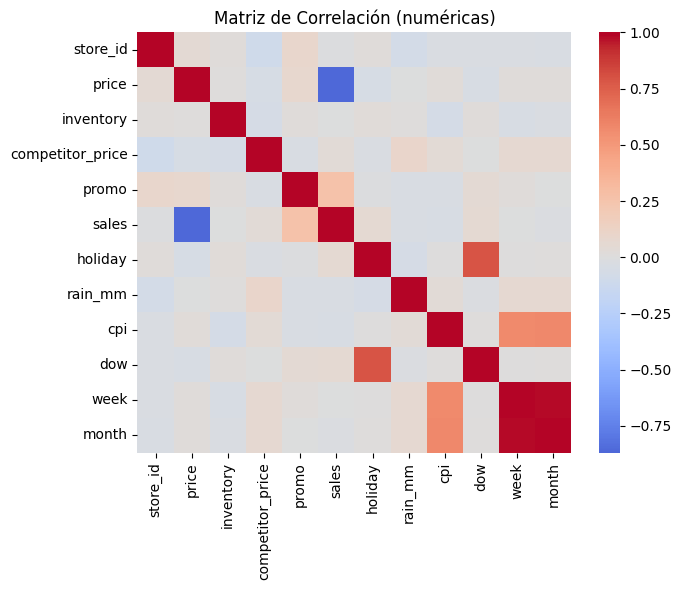

 Figura: docs/figures/corr_heatmap.png


<Figure size 640x480 with 0 Axes>

In [9]:
# --- Correlaciones numéricas ---
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
num = df.select_dtypes(include=[np.number])
corr = num.corr()
plt.figure(figsize=(7,6))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Matriz de Correlación (numéricas)')
plt.tight_layout(); plt.show()
plt.gcf().savefig(project_root / 'docs' / 'figures' / 'corr_heatmap.png', dpi=140)
print(" Figura: docs/figures/corr_heatmap.png")


Ventas con/ sin promo:


,count,mean,std,median
promo,,,,
0.0,320,86.63,16.69,89.0
1.0,80,97.90,16.99,100.0


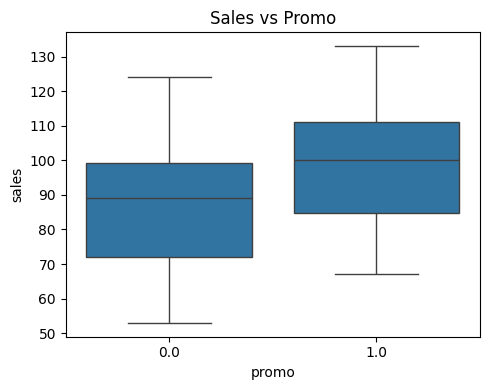

<Figure size 640x480 with 0 Axes>

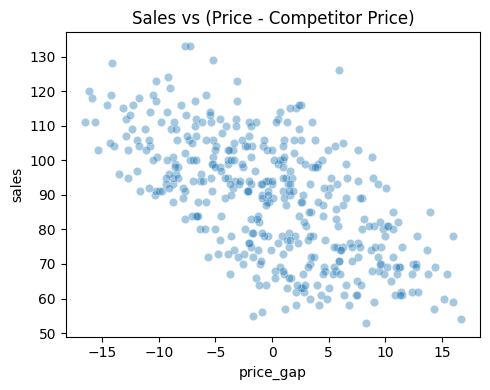

<Figure size 640x480 with 0 Axes>

In [10]:
# --- Efecto promo y gap de precio vs competidor ---
import matplotlib.pyplot as plt, seaborn as sns
df['price_gap'] = df['price'] - df.get('competitor_price', df['price'])

if 'promo' in df.columns:
    promo_stats = df.groupby('promo')['sales'].agg(['count','mean','std','median']).round(2)
    print("Ventas con/ sin promo:"); display(promo_stats)
    plt.figure(figsize=(5,4)); sns.boxplot(data=df, x='promo', y='sales')
    plt.title('Sales vs Promo'); plt.tight_layout(); plt.show()
    plt.gcf().savefig(project_root / 'docs' / 'figures' / 'sales_vs_promo_box.png', dpi=140)

# Relación sales vs price_gap
plt.figure(figsize=(5,4)); sns.scatterplot(data=df.sample(min(len(df), 5000), random_state=7), x='price_gap', y='sales', alpha=0.4)
plt.title('Sales vs (Price - Competitor Price)')
plt.tight_layout(); plt.show()
plt.gcf().savefig(project_root / 'docs' / 'figures' / 'sales_vs_pricegap.png', dpi=140)


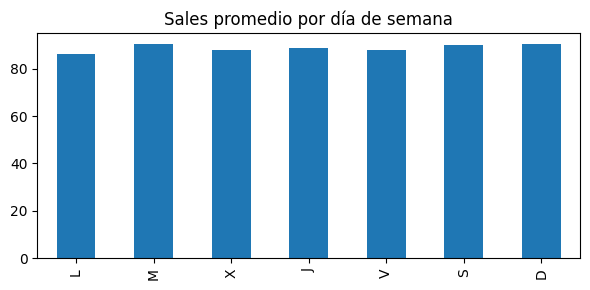

<Figure size 640x480 with 0 Axes>

In [11]:
# --- Estacionalidad semanal ---
import matplotlib.pyplot as plt
dow_map = ['L','M','X','J','V','S','D']
by_dow = df.groupby('dow')['sales'].mean()
by_dow.index = [dow_map[int(i)] if pd.notna(i) else i for i in by_dow.index]
ax = by_dow.reindex(['L','M','X','J','V','S','D']).plot(kind='bar', figsize=(6,3), title='Sales promedio por día de semana')
plt.tight_layout(); plt.show()
plt.gcf().savefig(project_root / 'docs' / 'figures' / 'sales_by_dow.png', dpi=140)


In [12]:
# --- Detección simple de outliers con z-score sobre ventas diarias agregadas ---
daily_sales = df.groupby('date', as_index=False)['sales'].sum().sort_values('date')
daily_sales['ma7'] = daily_sales['sales'].rolling(7, min_periods=3).mean()
daily_sales['std7'] = daily_sales['sales'].rolling(7, min_periods=3).std()
daily_sales['z'] = (daily_sales['sales'] - daily_sales['ma7']) / daily_sales['std7']
anoms = daily_sales.loc[daily_sales['z'].abs() >= 3].copy()
print("Anomalías detectadas (|z|>=3):", len(anoms))
display(anoms.head(10))
daily_sales.to_csv(project_root / 'docs' / 'eda_ventas_diarias_con_ma.csv', index=False)
print(" Guardado: docs/eda_ventas_diarias_con_ma.csv")


Anomalías detectadas (|z|>=3): 0


,date,sales,ma7,std7,z


 Guardado: docs/eda_ventas_diarias_con_ma.csv


In [13]:
# --- Top SKUs y Tiendas por ventas ---
top_n = 10
if 'sku' in df.columns:
    top_skus = df.groupby('sku')['sales'].sum().sort_values(ascending=False).head(top_n)
    print("Top SKUs:"); display(top_skus)
    top_skus.to_csv(project_root / 'docs' / 'top_skus.csv')
if 'store_id' in df.columns:
    top_stores = df.groupby('store_id')['sales'].sum().sort_values(ascending=False).head(top_n)
    print("Top Tiendas:"); display(top_stores)
    top_stores.to_csv(project_root / 'docs' / 'top_stores.csv')
print(" Guardados: docs/top_skus.csv y docs/top_stores.csv (si aplica)")


Top SKUs:


,sales
sku,
B,9378
C,9261
A,8954
D,7962


Top Tiendas:


,sales
store_id,
20.0,1516
29.0,1463
2.0,1207
24.0,1198
21.0,1156
30.0,1069
33.0,1062
19.0,1013
43.0,969


 Guardados: docs/top_skus.csv y docs/top_stores.csv (si aplica)


In [14]:
# --- Guardar dataset enriquecido adicional (opcional) ---
# Nota: el archivo principal ya se guardó antes como data/processed/sales.csv
# Aquí exportamos una versión con columnas auxiliares por si quieres examinar aparte.
enriched = df.copy()
enriched = enriched.sort_values('date')
try:
    # media móvil por SKU
    if 'sku' in enriched.columns:
        enriched['sales_ma7_sku'] = (enriched.sort_values(['sku','date'])
                                     .groupby('sku')['sales']
                                     .transform(lambda s: s.rolling(7, min_periods=3).mean()))
except Exception:
    pass
enriched.to_csv(project_root / 'data' / 'processed' / 'sales_enriched.csv', index=False)
print(" Guardado extra: data/processed/sales_enriched.csv")


 Guardado extra: data/processed/sales_enriched.csv
